In [16]:
import os
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

In [ ]:
HTML("""
<video width="640" height="480" controls>
  <source src="Videos/race_car.mp4" type="video/mp4">
</video>
""")

In [18]:
video_input_file_name = 'Videos/race_car.mp4'
# Explain each of  methods briefly

# Draw a rectangle on the frame
def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv.rectangle(frame, p1, p2, (0, 255, 0), 2, cv.LINE_AA)

# Display the rectangle on the frame
def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv.cvtColor(frameCopy, cv.COLOR_BGR2RGB)
    plt.imshow(frameCopy)
    plt.axis('off')
    plt.show()

# Display the text on the frame
def drawText(frame, text, position, color=(0, 255, 0)):
    cv.putText(frame, text, position, cv.FONT_HERSHEY_SIMPLEX, 1, color, 3, cv.LINE_AA)

In [34]:
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[3]

# GOTURN requires model files. If not available, fallback to CSRT.
if tracker_type == "GOTURN":
    print("Warning: GOTURN tracker requires goturn.prototxt and goturn.caffemodel files. Falling back to CSRT tracker.")
    tracker_type = "CSRT"

if tracker_type == "BOOSTING":
    tracker = cv.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv.legacy.TrackerMedianFlow.create()
elif tracker_type == "MOSSE":
    tracker = cv.legacy.TrackerMOSSE.create()
else:
    raise ValueError(f"Unknown tracker type: {tracker_type}")

In [28]:
# Read video
video = cv.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = "Videos/race_car-" + tracker_type + ".mp4"
video_out = cv.VideoWriter(video_output_file_name, cv.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

'Videos/race_car-CSRT.mp4'

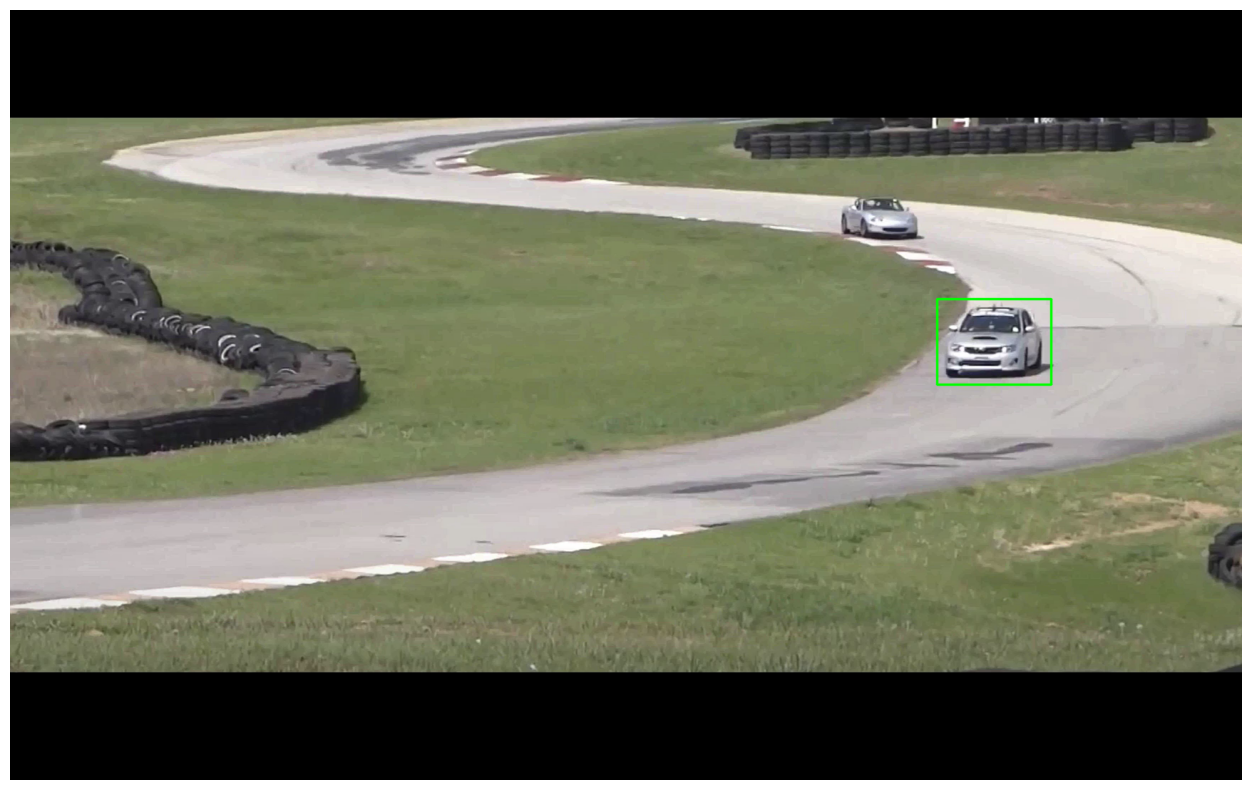

In [29]:
bbox = (1300, 405, 160, 120)
# bbox is the bounding box of the object to be tracked
displayRectangle(frame, bbox)

In [30]:
ok = tracker.init(frame, bbox)

while True:
    ok, frame = video.read()
    if not ok:
        break
    
    timer = cv.getTickCount()
    # timer is used to measure the time taken for tracking

    # Update tracker
    ok, bbox = tracker.update(frame)
    
    fps = cv.getTickFrequency() / (cv.getTickCount() - timer)
    # Explination: fps is frames per second, calculated using the tick count before and after tracking
    # tick is a measure of time in OpenCV, and getTickFrequency() gives the number of ticks per second

    if ok:
        # Tracking success
        drawRectangle(frame, bbox)
        drawText(frame, "Tracking success", (100, 80))
    else:
        # Tracking failure
        drawText(frame, "Tracking failure detected", (100, 80), color=(0, 0, 255))

    # Display FPS on the frame
    drawText(frame, f"FPS: {fps:.2f}", (100, 150))
    drawText(frame, f"Tracker: {tracker_type}", (100, 200))

    # Display result
    cv.imshow("Tracking", frame)
    video_out.write(frame)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
video_out.release()
# release meaning is to free up the resources used by the video capture and video writer
cv.destroyAllWindows()